In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.models import load_model
from patchify import patchify, unpatchify
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops

2024-01-26 02:02:29.402453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 02:02:29.402513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 02:02:29.403713: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 02:02:29.410809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Importing files custom objects for the model

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        y_pred = tf.cast(y_pred>0.5, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [3]:
def padder(image, patch_size):

    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [4]:
def roi_image(input_im):

    if len(input_im.shape) == 3 and input_im.shape[2] == 3:
        im_gray = cv2.cvtColor(input_im, cv2.COLOR_BGR2GRAY)
    elif len(input_im.shape) == 2:
        # If the input image is already grayscale, no need to convert
        im_gray = input_im
    else:
        # Handle other cases (e.g., images with more than 3 channels)
        raise ValueError("Unsupported number of channels in input image")

    kernel = np.ones((50, 50), dtype="uint8")

    im_e = cv2.dilate(im_gray, kernel, iterations=1)
    im_closing = cv2.erode(im_e, kernel, iterations=1)

    th, output_im = cv2.threshold(im_closing, 160, 255, cv2.THRESH_BINARY)

    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    area_of_interest = None
    largest_area = 0

    for i in range(1, len(stats)):
        x, y, w, h, area = stats[i]
        if area > largest_area:
            largest_area = area
            area_of_interest = (x, y, w, h)

    x, y, w, h = area_of_interest

    image = cv2.rectangle(input_im, (x, y), (x+w, y+h), (0, 0, 255), 2)

    roi = input_im[y:y+h, x:x+w]
    return roi, y, h, x, w

In [5]:
def predict_all(images, patch_size):

    predictions = []

    for image in images:
    
        image, _, _, _, _ = roi_image(image)
        image = padder(image, patch_size)
        
        patches = patchify(image, (patch_size, patch_size), step=patch_size)
        
        i = patches.shape[0]
        j = patches.shape[1]
        
        patches = patches.reshape(-1, patch_size, patch_size, 1)
        
        preds = model.predict(patches/255)
        
        preds_reshaped = preds.reshape(i, j, patch_size, patch_size)
        
        predicted_mask = unpatchify(preds_reshaped, (i*patch_size, j*patch_size))

        predictions.append(predicted_mask)

    return predictions

Creating code for boundary boxes - another way for recognizing objects

In [6]:
def bounding_boxes(predicted_mask, min_area_threshold=1500, max_instances=5):
    # Convert the mask to uint8 format
    predicted_mask = (predicted_mask * 255).astype(np.uint8)

    # Connected Components Labeling
    _, labels, stats, _ = cv2.connectedComponentsWithStats(predicted_mask)

    # Convert labels to bool to use as a binary mask
    binary_mask = labels > 0.05

    # Remove small objects using skimage's remove_small_objects
    cleaned_mask = remove_small_objects(predicted_mask, min_size=min_area_threshold)

    # Apply connected components labeling to the cleaned mask
    cleaned_labels = label(cleaned_mask)

    # Extract bounding boxes and masks for each remaining instance in the cleaned mask
    instance_masks = []
    bounding_boxes = []

    for region in regionprops(cleaned_labels):
        if len(instance_masks) >= max_instances:
            break

        mask = (cleaned_labels == region.label).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        bounding_box = cv2.boundingRect(contours[0])

        instance_masks.append(mask)
        bounding_boxes.append(bounding_box)

    return instance_masks, bounding_boxes

Impelementing image segmentation on the prediction masks functions

In [7]:
def instance_segmentation(image, threshold_area=2500):

    # Convert the image to the suitable type
    predicted_mask = (image * 255).astype(np.uint8)

    # Creating a binary mask
    _, thresholded = cv2.threshold(predicted_mask, 10, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > threshold_area]

    # Create an empty mask to draw the filtered contours
    labeled_image = np.zeros_like(predicted_mask)

    # Draw the filtered contours on the mask
    cv2.drawContours(labeled_image, filtered_contours, -1, (255), thickness=cv2.FILLED)

    # Connected Components Labeling
    _, labels, stats, _ = cv2.connectedComponentsWithStats(labeled_image)

    return labels

In [8]:
test_folder = 'task_4/Dataset/test'

file_list = os.listdir(test_folder)

test = []

for filename in file_list:
    if filename.endswith('.png'):
        input_image_path = os.path.join(test_folder, filename)

        input_image = cv2.imread(input_image_path, 0)

        test.append(input_image)

In [9]:
model = load_model('root_model.h5', custom_objects={'f1':f1, 'iou':iou})

2024-01-26 02:02:45.544190: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-26 02:02:45.544575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19490 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-01-26 02:02:45.545052: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-26 02:02:45.545352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6815 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6
2024-01-26 02:02:45.545638: W tensorflow/core/common_runt

In [10]:
predictions = predict_all(test, 256)

2024-01-26 02:02:49.721570: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


4/4 [==============================] - 1s 29ms/step


In [11]:
image = predictions[1]

In [12]:
image_test = test[0]
image_test, _, _, _, _ = roi_image(image_test)
image_test = padder(image_test, 256)

In [13]:
instance_masks, bounding_boxes = bounding_boxes(image)

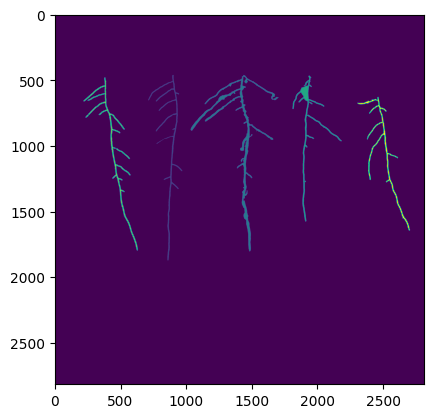

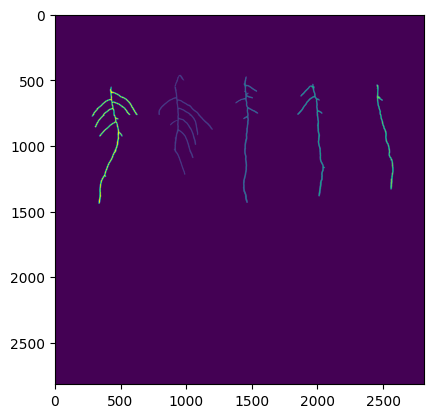

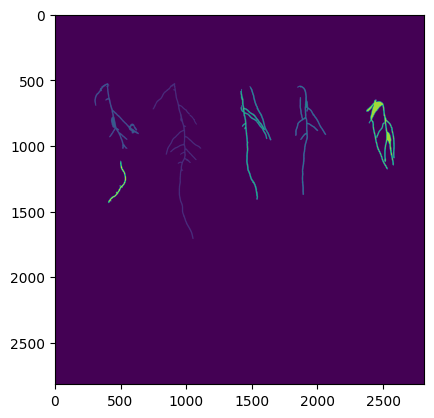

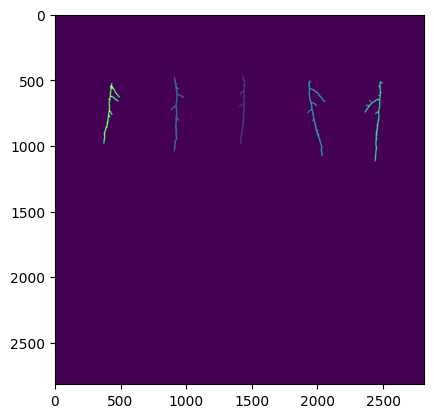

In [14]:
for i in range(4):
    output = instance_segmentation(predictions[i])
    plt.imshow(output)
    plt.show()